In [1]:
%load_ext autoreload

In [1]:

from pathlib import Path
from pytorch_lightning import callbacks
import pytorch_lightning as pl
import torch

from src import multitask_datamod
from src.multitask_lit import LitMultitask, LitClassification
from torch import nn

In [2]:
pl.seed_everything(42, workers=True)

PROJECT_DIR = ""
dataloader_params = {"batch_size": 8, "num_workers": 6, "pin_memory": False}
data_module = multitask_datamod.MultitaskDataModule(PROJECT_DIR, dataloader_params)

seg_weights = 1 / torch.Tensor(
    [
        11611728,
        8578042,
        1308322,
        3535427,
        8258474,
        23949931,
        35664840,
        31453241,
        4864604,
        5747842,
        7347520,
        1349733,
        57555778,
    ]
)

scene_weights = 1 / torch.Tensor([66.0, 192.0, 114.0, 63.0, 92.0, 149.0, 119.0])



Global seed set to 42


In [4]:
trainer = pl.Trainer(accelerator="gpu", max_epochs=50)
model = LitClassification(learning_rate=1e-7, weights=scene_weights)
# y=model(torch.rand(3,3, 480, 640))


SyntaxError: positional argument follows keyword argument (2362918094.py, line 3)

In [11]:
import re

trainable_params =[p for name, p in model.named_parameters() if not bool(re.search('decoder|segmentation',name))] 
# for name, p in model.named_parameters():
#     if "classifier" not in name:
#         print(name)
# model.requires_grad_(False)
# for p in trainable_params:
#     p.requires_grad = True

# trainable_params
# list(model.parameters())
trainable_params

['model.encoder.conv1.weight',
 'model.encoder.bn1.weight',
 'model.encoder.bn1.bias',
 'model.encoder.layer1.0.conv1.weight',
 'model.encoder.layer1.0.bn1.weight',
 'model.encoder.layer1.0.bn1.bias',
 'model.encoder.layer1.0.conv2.weight',
 'model.encoder.layer1.0.bn2.weight',
 'model.encoder.layer1.0.bn2.bias',
 'model.encoder.layer1.1.conv1.weight',
 'model.encoder.layer1.1.bn1.weight',
 'model.encoder.layer1.1.bn1.bias',
 'model.encoder.layer1.1.conv2.weight',
 'model.encoder.layer1.1.bn2.weight',
 'model.encoder.layer1.1.bn2.bias',
 'model.encoder.layer1.2.conv1.weight',
 'model.encoder.layer1.2.bn1.weight',
 'model.encoder.layer1.2.bn1.bias',
 'model.encoder.layer1.2.conv2.weight',
 'model.encoder.layer1.2.bn2.weight',
 'model.encoder.layer1.2.bn2.bias',
 'model.encoder.layer2.0.conv1.weight',
 'model.encoder.layer2.0.bn1.weight',
 'model.encoder.layer2.0.bn1.bias',
 'model.encoder.layer2.0.conv2.weight',
 'model.encoder.layer2.0.bn2.weight',
 'model.encoder.layer2.0.bn2.bias',
 

In [6]:
any()

TypeError: any() takes exactly one argument (0 given)

In [6]:
trainer.fit(
    model=model,
    datamodule=data_module
    # ckpt_path="/home/piotr/SensorsArticle2022/logs/23.11-max_real/version_0/checkpoints/epoch=19-step=300.ckpt",
)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [5]:
lr_finder = trainer.tuner.lr_find(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /mnt/c/Users/piotr.hondra/Documents/inz/indoor-semantic-segmentation/.lr_find_ab424815-7bfd-4247-bd3f-58a711eb802a.ckpt


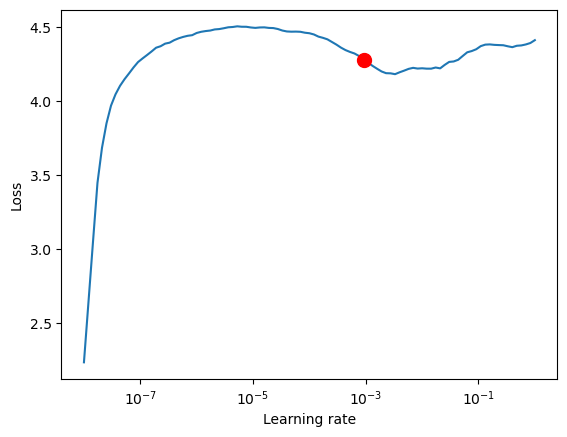

In [6]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [7]:
lr_finder.suggestion()

0.0009120108393559097

In [ ]:
from torchviz import make_dot
# make_dot()

In [ ]:

y=model(torch.rand(3,3, 480, 640))
y[0].mean() + y[1].mean()


In [ ]:
make_dot(y[0].mean() + y[1].mean(), params=dict(model.named_parameters()))

In [ ]:

logger = pl.loggers.WandbLogger(
    project="multitask-19.12",
    # name="baseline",
    log_model=True,
)
lr_monitor = callbacks.LearningRateMonitor(logging_interval="step")
trainer = pl.Trainer(
    auto_lr_find=True,
    accelerator="gpu",
    devices=1,
    max_epochs=50,
    # max_steps=100,
    # val_check_interval=0.25,
    precision=16,
    # log_every_n_steps=5,
    logger=logger,
    callbacks=[lr_monitor],
    # callbacks=[early_stopping],
    # accumulate_grad_batches=3,
    # overfit_batches=2,
)
model = LitMultitask(
    learning_rate=1e-4, scene_weights=scene_weights, seg_weights=seg_weights
)
trainer.fit(
    model=model,
    datamodule=data_module
    # ckpt_path="/home/piotr/SensorsArticle2022/logs/23.11-max_real/version_0/checkpoints/epoch=19-step=300.ckpt",
)
trainer.test(model=model, datamodule=data_module, verbose=True)


In [ ]:
import segmentation_models_pytorch as smp
segmentator = smp.DeepLabV3(
    encoder_weights="imagenet",
    classes=13,
)

In [ ]:
class MultitaskNet(nn.Module):
    def __init__(self, scene_classes=7, segmentation_classes=13) -> None:
        super().__init__()
        segmentator = smp.DeepLabV3(
            encoder_weights="imagenet",
            classes=segmentation_classes,
        )
        self.encoder = segmentator.encoder
        self.decoder = segmentator.decoder
        self.segmentation_head = segmentator.segmentation_head
        num_filters = self.encoder.out_channels[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.BatchNorm1d(num_filters),
            nn.Dropout(p=0.25),
            nn.Linear(num_filters, out_features=256, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=256, out_features=scene_classes, bias=False),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        features = self.encoder(x)
        scenes = self.classifier(features[-1])
        segm = self.decoder(*features)
        segm = self.segmentation_head(segm)
        return segm, scenes

    #     representations = self.backbone(x)
    #     segmentation_mask = self.decoder(representations)
    #     classification_label = self.classifier(representations)
    #     return segmentation_mask, classification_label


In [1]:
mdl = MultitaskNet()
mdl(torch.rand(3,3, 480, 640))

NameError: name 'MultitaskNet' is not defined